In [1]:
# Import Dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

The following code establishes a connection to an SQLite database - hawaii.sqlite. The script uses SQLAlchemy, a Object Relational Mapper (ORM) library, which enables interaction with the database.

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

The automap_base function creates a new automap base, which serves as the foundation for reflecting the database schema into Python classes.

In [4]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine)

In [5]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['station', 'measurement']

In [6]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

A new session is created using the Session class and the engine. The session serves as a link between Python and the SQLite database, allowing for data queries and manipulation.

In [7]:
# Create a session
#Link Python to the database by creating a SQLAlchemy session
session = Session(engine)

# Exploratory Precipitation Analysis

In this part, we perform an exploratory precipitation analysis. We first find the most recent date in the dataset, and then we design a query to retrieve the last 12 months of precipitation data starting from the most recent data point in the database.

In [8]:
#Preview the first row of the measurement table
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1e1a5d92ab0>,
 'station': 'USC00519397',
 'prcp': 2.0,
 'tobs': 18.3,
 'date': '2010-01-01',
 'id': 0}

In [9]:
# Find the most recent date in the data set.
date_query = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print("Most recent date in the data set:", date_query)

Most recent date in the data set: ('2017-08-23',)


In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# STEP 1.  
# Starting from the most recent data point in the database.
# Convert the most recent date to a datetime object.
for date in date_query:
    latest_date = pd.to_datetime(date)

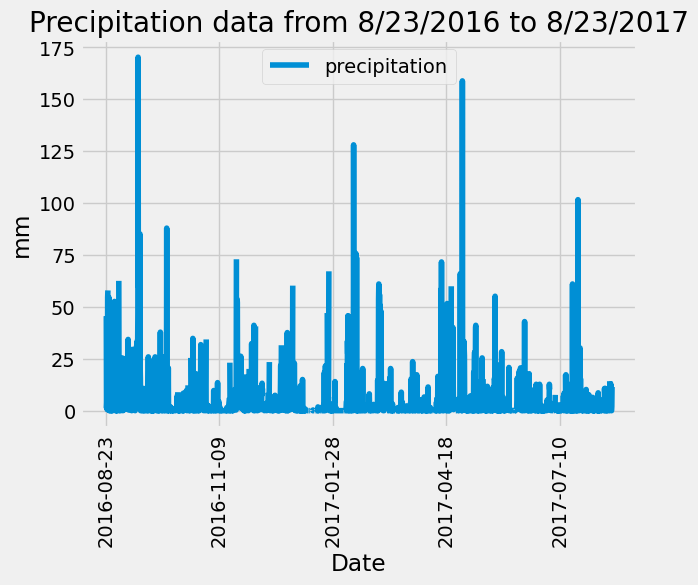

In [11]:
# STEP 2. 
# Calculate the date one year from the last date in data set.
date_one_year_ago = dt.date(latest_date.year-1,
                            latest_date.month,
                            latest_date.day)
# STEP 3
# Perform a query to retrieve the data and precipitation scores
# for the last 12 months using the session.query() function and filter the results based on the one_year variable

one_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date_one_year_ago).all()

# STEP 4
# Save the query results as a Pandas DataFrame. Explicitly set the column names
one_year_df = pd.DataFrame(one_year)

#Explicitly set the column names
one_year_df.rename(columns={"date":"Date",
                            "prcp":"Precipitation"},
                            inplace=True)
# STEP 5
#Sort the DataFrame by date
one_year_df.sort_values(by="Date", ascending=True, inplace=True)

# STEP 6
# Use Pandas Plotting with Matplotlib to plot the data
one_year_df.plot(x="Date",y="Precipitation")
plt.xlabel("Date")
plt.ylabel("mm")
plt.xticks(rotation=90)
plt.legend(["precipitation"],loc="best")
plt.title("Precipitation data from 8/23/2016 to 8/23/2017")
plt.savefig("Image/prcp_plot.png",bbox_inches="tight")
plt.show()

In [12]:
# STEP 7
# Use Pandas to calculate the summary statistics for the precipitation data
one_year_df.describe()

,Precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In this part we perform an exploratory station analysis. We calculate the total number of stations, find the most active stations, and perform a temperature observation data analysis for the most active station.

In [13]:
#Preview the first row of the station table
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1e1a67b0650>,
 'latitude': 21.2716,
 'elevation': 0.914,
 'longitude': -157.8168,
 'id': 0,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US'}

In [14]:
# STEP 1
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station.station).distinct().count()
print("Total number of stations in the dataset:", total_stations)

Total number of stations in the dataset: 9


In [15]:
# STEP 2.1
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# STEP 2.2
#Find station with the greatest number of observations
greatest_station = active_stations[0][0]
print(f"The greatest number of observations:", greatest_station)

The greatest number of observations: USC00519281


### Answer the following question: which station id has the greatest number of observations?
Station ID USC00519281 has 2772 rows

In [17]:
# STEP 2.3
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
greatest_station_summary = session.query(func.min(Measurement.tobs), 
                                         func.max(Measurement.tobs),
                                         func.avg(Measurement.tobs)).filter(Measurement.station == greatest_station)
for row in greatest_station_summary:
    print(row)

(12.2, 29.4, 22.03582251082252)


In [18]:
# STEP 3.1
# Using the most active station id
# Query the last 12 months of temperature observation data(TOBS) for this station and plot the results as a histogram
station_ID_temps = session.query(Measurement.date, Measurement.tobs).\
        filter(func.strftime(Measurement.date) >= date_one_year_ago, Measurement.station == greatest_station).\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()

# STEP 3.2
# Save the query results to a Pandas DataFrame
station_ID_temps = pd.DataFrame(station_ID_temps, columns=['Measurement Date', 'Temperature'])
station_ID_temps.head()

,Measurement Date,Temperature
0,2016-08-23,25.0
1,2016-08-24,25.0
2,2016-08-25,26.7
3,2016-08-26,26.7
4,2016-08-27,23.9


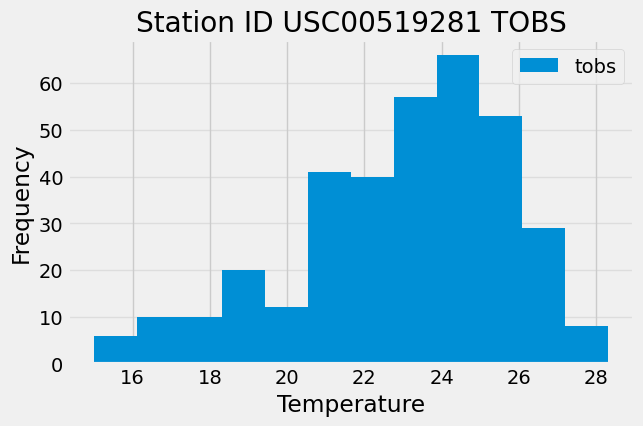

In [19]:
# STEP 3.3
#Plot the results as a histogram with bins=12 for the last year of data
#using tobs as the column to count
plt.figure(figsize = (6.5,4))
n, bins, patches = plt.hist(x=station_ID_temps["Temperature"], bins = 12, label='tobs')
plt.grid(axis='y', alpha=0.5)
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Station ID USC00519281 TOBS')
plt.savefig("Image/Station_ID.png",bbox_inches="tight")
plt.show()

# Close Session

In [20]:
# STEP 4
# Close Session
session.close()